In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
party_the_3rd = os.path.join(parent, 'third_party')
for path_ in [parent, party_the_3rd]:
    if path_ not in (cur_path:=sys.path):
        sys.path = [path_] + cur_path
print(sys.path)


import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import kradagrad
import shampoo

from resnet_cifar10.trainer import model_names, train, validate, save_checkpoint, AverageMeter, accuracy



['/home/jmei/code/experiments/kradagrad/third_party', '/home/jmei/code/experiments/kradagrad', '/home/jmei/code/experiments/kradagrad/experiments', '/home/jmei/miniconda3/envs/krad/lib/python310.zip', '/home/jmei/miniconda3/envs/krad/lib/python3.10', '/home/jmei/miniconda3/envs/krad/lib/python3.10/lib-dynload', '', '/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages']


/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as xforms
import torchvision.datasets as datasets

from resnet_cifar10 import resnet

def train_run(args):
    best_prec1 = 0

    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    model = torch.nn.DataParallel(resnet.__dict__[args.arch]())
    model.cuda()

    # resume from a checkpoint
    found = False
    final_path = os.path.join(args.save_dir, 'model_{}.th'.format(args.optimizer))
    ckpt_path = os.path.join(args.save_dir, 'checkpoint_{}.th'.format(args.optimizer))
    if os.path.isfile(final_path):
        fn = final_path
        found = True
    elif os.path.isfile(ckpt_path):
        fn = ckpt_path
        found = True
    else:
        found = False
    if found:
        print(" - found checkpoint '{}'".format(fn))
        checkpoint = torch.load(fn)
        args.start_epoch = checkpoint['epoch']
        if args.start_epoch < args.epochs:
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print(" - loaded checkpoint (epoch {})".format(args.start_epoch))
        else:
            print(" - model done training, loading saved loss and precisions")
            loss_fn = os.path.join(args.save_dir, 'loss_{}.npy'.format(args.optimizer))
            prec_fn = os.path.join(args.save_dir, 'prec_{}.npy'.format(args.optimizer))
            loss_s = np.load(loss_fn)
            prec_s = np.load(prec_fn)
            print("     loss '{}'".format(loss_fn))
            print("     prec '{}'".format(prec_fn))
            return loss_s, prec_s
    else:
        print(" - no checkpoint found in '{}'".format(args.save_dir))

    cudnn.benchmark = True

    normalize = xforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    xforms_tr = [xforms.RandomHorizontalFlip(), xforms.RandomCrop(32, 4), xforms.ToTensor(), normalize]

    dataset_to_use = datasets.CIFAR10 if args.data == 'CIFAR10' else datasets.CIFAR100 if args.data == 'CIFAR100' else None
    dataset_tr = dataset_to_use(root='./data', train=True, transform=xforms.Compose(xforms_tr), download=True)
    dataset_va = dataset_to_use(root='./data', train=False, transform=xforms.Compose([xforms.ToTensor(), normalize]))

    train_loader = torch.utils.data.DataLoader(dataset_tr, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(dataset_va, batch_size=128, shuffle=False, num_workers=args.workers, pin_memory=True)

    # define loss function (criterion)
    criterion = nn.CrossEntropyLoss().cuda()

    if args.half:
        model.half()
        criterion.half()

    ## choose optimizer
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    elif args.optimizer == 'ada':
        optimizer = torch.optim.Adam(model.parameters(), args.lr,
                                weight_decay=args.weight_decay)
    elif args.optimizer == 'shampoo':
        hps = shampoo.ShampooHyperParams(
            matrix_eps=1e-6,  weight_decay=args.weight_decay, graft_type=0, beta2=args.momentum,
            block_size=27 if args.arch in ['resnet32', 'resnet56'] else 125,
        )
        optimizer = shampoo.Shampoo(model.parameters(), lr=args.lr, hyperparams=hps)
    elif args.optimizer == 'krad':
        hps = shampoo.ShampooHyperParams(
            matrix_eps=1e0,  weight_decay=args.weight_decay, graft_type=0, beta2=args.momentum,
            block_size=27 if args.arch in ['resnet32', 'resnet56'] else 125,
        )
        optimizer = kradagrad.KradagradPP(model.parameters(), lr=args.lr, hyperparams=hps)
    else:
        raise ValueError('unknown optimizer: {}'.format(args.optimizer))
    
    if args.optimizer in ['sgd', 'ada']:
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150], last_epoch=args.start_epoch - 1)
    
    ## End optimizer setup
    
    
    if args.evaluate:
        loss_va, prec1_va = validate(val_loader, model, criterion)
        return loss_va, prec1_va

    loss_s = []
    prec_s = []
    for epoch in tqdm(range(args.start_epoch, args.epochs), 'Epoch', ncols=80):

        # train for one epoch
        loss_tr, prec1_tr = train(train_loader, model, criterion, optimizer, epoch, args)
        if args.optimizer in ['sgd', 'ada']:
            lr_scheduler.step()

        # evaluate on validation set
        loss_va, prec1_va = validate(val_loader, model, criterion, args)
        
        loss_s.append((loss_tr, loss_va))
        prec_s.append((prec1_tr, prec1_va))
        # remember best prec@1 and save checkpoint
        is_best = prec1_va > best_prec1
        best_prec1 = max(prec1_va, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
                'initial_lr': args.lr,
            }, is_best, filename=os.path.join(args.save_dir, 'checkpoint_{}.th'.format(args.optimizer)))

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'initial_lr': args.lr,
        }, is_best, filename=os.path.join(args.save_dir, 'model_{}.th'.format(args.optimizer)))
    np.save(os.path.join(args.save_dir, 'loss_{}.npy'.format(args.optimizer)), np.array(loss_s))
    np.save(os.path.join(args.save_dir, 'prec_{}.npy'.format(args.optimizer)), np.array(prec_s))
    return loss_s, prec_s

In [3]:


arch = 'resnet32'
data = 'CIFAR10'

epochs = 2
#epochs = 200

exp_name = 'epoch{}'.format(epochs)
optimizer_s = ['sgd', 'ada', 'krad', 'shampoo']
loss_s = {}
prec_s = {}
for optimizer_ in optimizer_s:

    args = argparse.Namespace(
        arch='resnet32',
        data=data,
        workers=4,
        optimizer=optimizer_,
        epochs=epochs,
        start_epoch=0,
        lr=0.1 if optimizer_ in ['sgd', 'krad'] else 0.05, # lower to prevent nan's
        momentum=0.9,
        weight_decay=1e-4,
        evaluate=False,
        pretrained=False,
        
        half=True,
        batch_size=1024,
        #half=optimizer_ in ['sgd', 'ada'],
        #batch_size=1024 if optimizer_ in ['sgd', 'ada'] else 256,
        
        save_dir='{}_{}_{}_ckpts'.format(arch, data, exp_name),
        save_every=5
    )
    # reproducible
    torch.manual_seed(4750)
    print("\n=> Training using optimizer '{}'\n".format(optimizer_))
    loss_, prec_ = train_run(args)
    loss_s[optimizer_] = loss_
    prec_s[optimizer_] = prec_



=> Training using optimizer 'sgd'

 - found checkpoint 'resnet32_CIFAR10_epoch2_ckpts/model_sgd.th'
 - model done training, loading saved loss and precisions
     loss 'resnet32_CIFAR10_epoch2_ckpts/loss_sgd.npy'
     prec 'resnet32_CIFAR10_epoch2_ckpts/prec_sgd.npy'

=> Training using optimizer 'ada'

 - found checkpoint 'resnet32_CIFAR10_epoch2_ckpts/model_ada.th'
 - model done training, loading saved loss and precisions
     loss 'resnet32_CIFAR10_epoch2_ckpts/loss_ada.npy'
     prec 'resnet32_CIFAR10_epoch2_ckpts/prec_ada.npy'

=> Training using optimizer 'krad'

 - found checkpoint 'resnet32_CIFAR10_epoch2_ckpts/model_krad.th'
 - model done training, loading saved loss and precisions
     loss 'resnet32_CIFAR10_epoch2_ckpts/loss_krad.npy'
     prec 'resnet32_CIFAR10_epoch2_ckpts/prec_krad.npy'

=> Training using optimizer 'shampoo'

 - no checkpoint found in 'resnet32_CIFAR10_epoch2_ckpts'
Files already downloaded and verified


Epoch: 100%|█████████████████████████████████████| 2/2 [07:55<00:00, 237.78s/it]


sgd [[2.59880031 2.11322344]
 [1.83405687 1.81767031]]
ada [[nan nan]
 [nan nan]]
krad [[2.98366    2.21047812]
 [2.11254438 2.04606094]]
shampoo [(nan, nan), (nan, nan)]


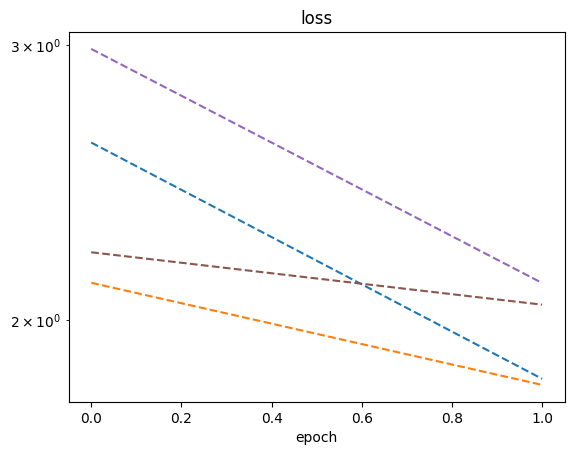

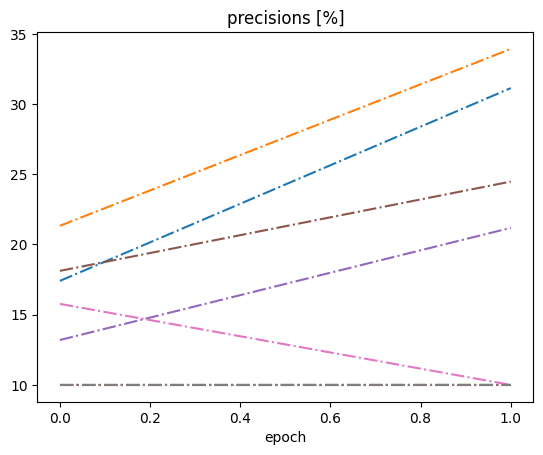

In [17]:
for opt_ in optimizer_s:
    print(opt_, loss_s[opt_])
plt.figure()
for opt_name_ in optimizer_s:
    plt.semilogy(loss_s[opt_name_], '--')
plt.xlabel('epoch')
plt.title('loss')


plt.figure()
for opt_name_ in optimizer_s:
    plt.plot(prec_s[opt_name_], '-.')
plt.xlabel('epoch')
plt.title('precisions [%]')

plt.show()

In [9]:
# common optimizer hyperparams
lr = 5e-3
seed_exp = 95054

# training settings
n_it = 320
val_int = 4
it_val = [x for x in range(n_it) if x % val_int == val_int - 1]


# Optimizers
opt_names = ['sgd', 'ada', 'shampoo', 'shampoo ONS', 'krad', 'krad ONS']
loss_tr = {}
loss_va = {}
hps = [shampoo.ShampooHyperParams(matrix_eps=m_, graft_type=g_, block_size=b_, inverse_exponent_override=i_) for (m_, g_, b_, i_) in (
    
    [1e-2, 1, np.inf, 0],  # SGD
    [1e-2, 2, np.inf, 0],  # Adagrad
    [1e-6, 0, 8, 0],          # Shampoo
    [1e-6, 0, 8, 2],          # Shampoo ONS

    [1e0, 0, 8, 0],            # Krad
    [1e0, 0, 8, 2],            # Krad ONS
)]

classes = [shampoo.Shampoo] * 4 + [kradagrad.KradagradPP] * 2

opts = [class_(model.parameters(), lr=lr, hyperparams=hp_) for (class_, hp_) in zip(classes, hps)]

for opt_name_, opt_ in zip(opt_names, opts):
    print('Using {}'.format(opt_name_))
    reinit(model, seed_exp)
    # `retain_graph` still required for some reason... haven't figured out why
    loss_tr_, loss_va_ = simple_train_run(model, loss_fn, n_it, opt_, val_int, retain_graph=True)
    loss_tr[opt_name_] = loss_tr_
    loss_va[opt_name_] = loss_va_


Using sgd


Epoch:  22%|█████████████████████████████████████▎                                                                                                                                | 72/320 [00:05<00:19, 12.93it/s]


KeyboardInterrupt: 

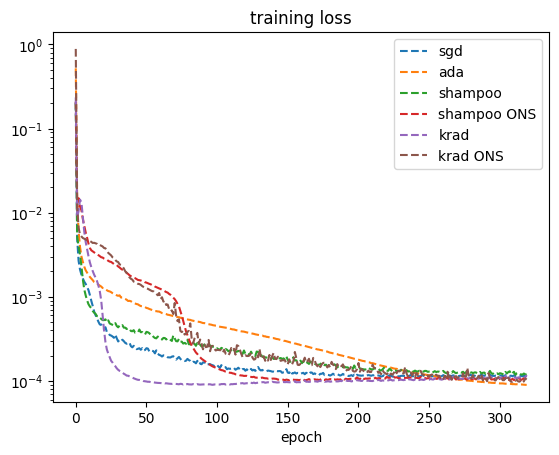

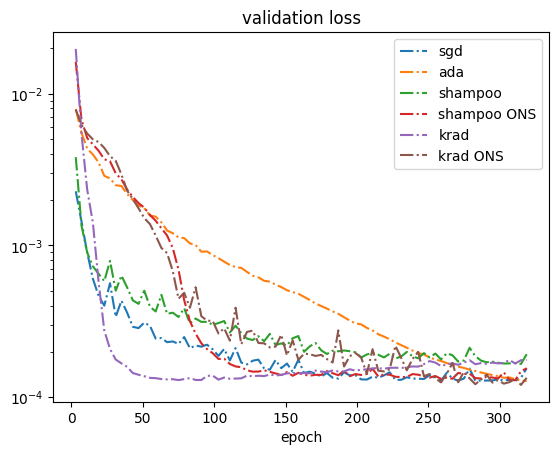

In [7]:
plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(range(n_it), loss_tr[opt_name_], '--')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('training loss')

plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(it_val, loss_va[opt_name_], '-.')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('validation loss')

plt.show()